Are soccer referees more likely to give red cards to dark skin toned players than light skin toned players?

Do a logistic regression. Preferably a mixed effect model. Where we can control for all of the variables, and measure the effect of skin tone.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
redcard_1 = pd.read_csv("./data/redcard_1.csv")
redcard_2 = pd.read_csv("./data/redcard_2.csv")

In [3]:
# lets combine the two data frames and drop some fields
redcard = pd.concat([redcard_1, redcard_2])
redcard = redcard.drop(columns=['Unnamed: 0', 'photoID'])

### Data exploration

In [4]:
#redcard.head(1)

In [5]:
# this is a nice (initial) way to get a count of missing data, to see which fields are problematic and need to be dropped or imputed
# next we can do count plots to see the different values for each categorical variable
# and do histogram plots of continuous variables

In [6]:
#redcard_1.count()

In [7]:
#redcard_2.count()

In [8]:
# there are two skin ratings, so take the average?
# could use birthday to calculate age
# then we have a bunch of variables at the end for implicit/explicit bias of the ref country. 
    # rather than controlling for specific ref, we could use that score.

In [9]:
# impute height and weight as mean
redcard.loc[redcard.height.isnull(),'height'] = redcard.height.mean()
redcard.loc[redcard.weight.isnull(),'weight'] = redcard.weight.mean()

In [10]:
# drop rows with na for the rest of data, because they seem like important variables that I don't want to impute
# if I have time later, I could come back and figure out a way to impute this data
redcard = redcard.dropna()

In [11]:
# take average of two rating of skin tone
redcard['skintone'] = redcard[['rater1','rater2']].mean(axis=1)

In [12]:
# remove rows where more than one redcard listed
redcard = redcard.loc[redcard.redCards <= 1]

In [13]:
# ['victories','ties','defeats','goals'2,'nIAT','seIAT','nExp','seExp']
# ['meanIAT','meanExp']
continuous_variables = ['skintone','height','weight','games']

In [14]:
# ['yellowCards','yellowReds']
response_variable = ['redCards']

In [15]:
# ['club','refCountry']
categorical_variables = ['leagueCountry','position']

In [16]:
id_variables = ['playerShort','player','refNum']

<Figure size 432x288 with 0 Axes>

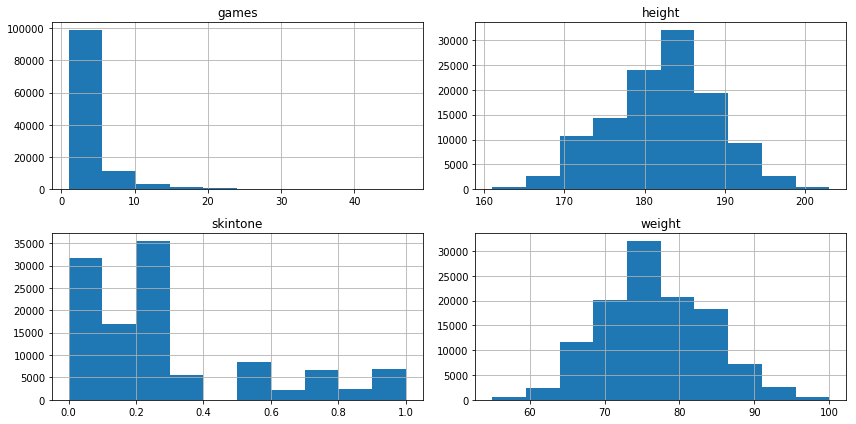

In [17]:
# plot some histograms
plt.figure()
plt.clf()
redcard[continuous_variables].hist(figsize=(12,6))
plt.tight_layout()

In [18]:
# should I aggregate the data? There are multiple rows per player....this might actually allow me to impute some data. 
# but really wouldn't be helpful otherwise?
#redcard_1.shape[0]
#redcard_1.playerShort.nunique()

<Figure size 432x288 with 0 Axes>

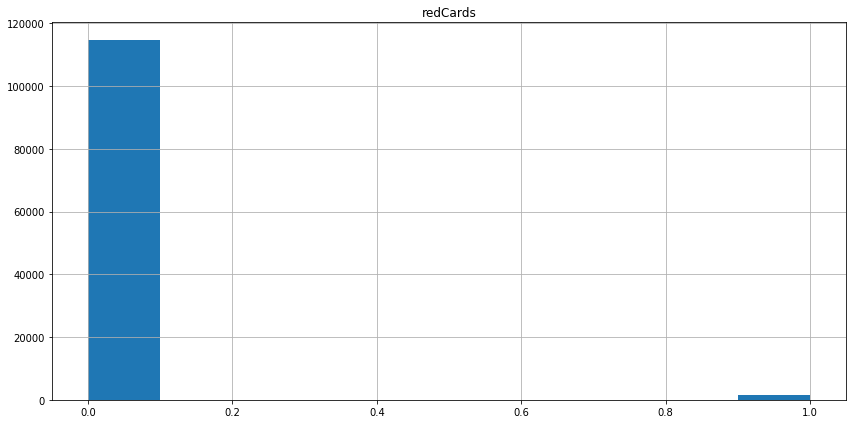

In [19]:
# plot some histograms
plt.figure()
plt.clf()
redcard[response_variable].hist(figsize=(12,6))
plt.tight_layout()

In [20]:
# we're going to have a serious class imbalance problem. Should I include yellowReds? Or focus on just reds?
# for now let's just focus on outright reds

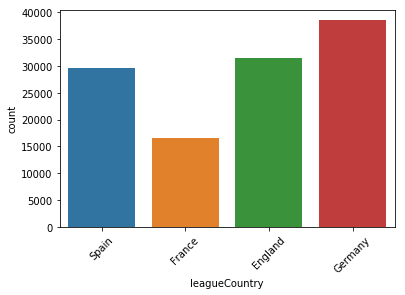

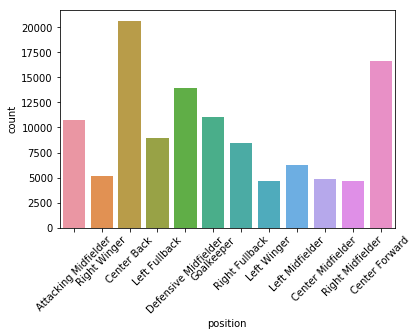

In [21]:
for column in categorical_variables:
    sns.countplot(x=column, data=redcard)
    plt.xticks(rotation=45)
    plt.show()

In [22]:
X_continuous = redcard[continuous_variables]
X_categorical = redcard[categorical_variables]
Y = redcard[response_variable]

In [23]:
# this encoding ok for random forests
# and ok for GLMM?
#from sklearn import preprocessing
#le = preprocessing.LabelEncoder()
#X_categorical = X_categorical.apply(le.fit_transform)

In [24]:
# dummy variable encoding for logistic regression
X_categorical = pd.get_dummies(X_categorical['position'])

In [25]:
X = pd.concat([X_continuous,X_categorical], axis=1)

In [26]:
#create training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.35,random_state=42)

In [27]:
# combine this with cross-validation
# Is SMOTE needed only for accuracy, or does it also effect the significance of coefficients we might be interested in
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X, Y)

/Users/codyschank/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/codyschank/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
import statsmodels.api as sm
logit = sm.Logit(Y_train, X_train)
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.063909
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:               redCards   No. Observations:                75394
Model:                          Logit   Df Residuals:                    75378
Method:                           MLE   Df Model:                           15
Date:                Thu, 25 Oct 2018   Pseudo R-squ.:                 0.06468
Time:                        13:01:07   Log-Likelihood:                -4818.3
converged:                       True   LL-Null:                       -5151.6
                                        LLR p-value:                2.598e-132
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
skintone                 0.2176      0.114      1.917      0.055      -0.005       0.440